In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import sys
from scipy import sparse
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pickle

In [2]:
e_features = pd.read_csv('extracted_features.csv', index_col=0)
df = pd.read_csv('prepped_data.csv', index_col=0)

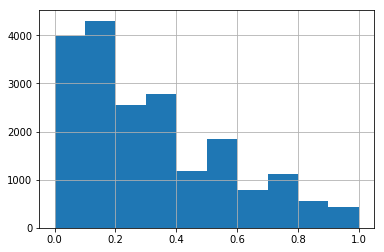

In [3]:
# distribution of humna judgement
df['truthJudgments'].apply(lambda x: np.mean(eval(x))).hist()

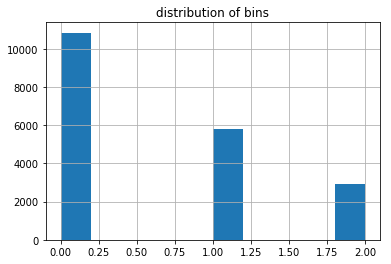

In [4]:
# make bins 
# 0-0.33, not clickbaits
# 0.33-0.66, could be clickbaits
# 0.66+ definite clickbaits
df['new_label']  = pd.cut(df['truthJudgments'].apply(lambda x: np.mean(eval(x))), [-1,0.33,0.66,1.01],labels =[0,1,2])
df['new_label'].hist()
plt.title('distribution of bins')
plt.show()

In [5]:
# proportion of each class
print('non clickbait: ', sum(df['new_label']==0)/len(df['new_label']))
print('maybe clickbait: ', sum(df['new_label']==1)/len(df['new_label']))
print('definite clickbait: ', sum(df['new_label']==2)/len(df['new_label']))

non clickbait:  0.5549186201248848
maybe clickbait:  0.2966526768348859
definite clickbait:  0.1484287030402293


In [6]:
X = df[['postText', 'targetTitle','targetDescription', 'targetKeywords']].join(e_features)
X['postText'] = X['postText'].fillna('')
X['targetDescription'] = X['targetDescription'].fillna('')
X['targetKeywords'] = X['targetKeywords'].fillna('')
y = df['new_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [7]:
# vectorize training text fields
tw_tokenizer = nltk.tokenize.TweetTokenizer()
tt_tokenizer = nltk.tokenize.TweetTokenizer()
td_tokenizer = nltk.tokenize.TweetTokenizer()
tk_tokenizer = nltk.tokenize.TweetTokenizer()
tw_vectorizer = CountVectorizer(lowercase=False,tokenizer=tw_tokenizer.tokenize, ngram_range= (1,5),analyzer= 'word')
tt_vectorizer = CountVectorizer(lowercase=False,tokenizer=tt_tokenizer.tokenize, ngram_range= (1,5),analyzer= 'word')
td_vectorizer = CountVectorizer(lowercase=False, tokenizer=td_tokenizer.tokenize, ngram_range = (1,4), analyzer = 'word')
tk_vectorizer = CountVectorizer(lowercase=False, tokenizer=tk_tokenizer.tokenize, ngram_range = (1,4), analyzer = 'word')
X_train_tdvec_bow = td_vectorizer.fit_transform(X_train['targetDescription'])
X_train_twvec_bow = tw_vectorizer.fit_transform(X_train['postText'])
X_train_ttvec_bow = tt_vectorizer.fit_transform(X_train['targetTitle'])
X_train_tkvec_bow = tk_vectorizer.fit_transform(X_train['targetKeywords'])

# vectorize testing text fields
X_test_twvec_bow = tw_vectorizer.transform(X_test['postText'])
X_test_tdvec_bow = td_vectorizer.transform(X_test['targetDescription'])
X_test_ttvec_bow = tt_vectorizer.transform(X_test['targetTitle'])
X_test_tkvec_bow = tk_vectorizer.transform(X_test['targetKeywords'])

In [8]:
# models
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000)
xgb = XGBClassifier(n_estimators=3000,gamma = 2, max_depth=1,n_jobs=8)
rf = RandomForestClassifier()
models =[ lr,xgb, rf]
names = ['Logistic Regression','XGB', 'Random Forest']
results ={}

In [9]:
# using comnbined features
for clf, name in zip(models,names):
    print(name)
    sub_X_train = sparse.hstack([X_train_tdvec_bow, X_train_ttvec_bow, X_train_twvec_bow,X_train_tkvec_bow ,X_train.iloc[:,4:].values])
    sub_X_test = sparse.hstack([X_test_tdvec_bow, X_test_ttvec_bow, X_test_twvec_bow,X_test_tkvec_bow,X_test.iloc[:,4:].values])
    clf.fit(sub_X_train,y_train)
    pred = clf.predict(sub_X_test)

    results[name] = classification_report(y_test, pred, target_names=['Non Clickbaits', 'Maybe Clickbaits', 'Definite Clickbaits'], output_dict = True)

Logistic Regression


/Users/tianyuyang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


XGB
Random Forest


/Users/tianyuyang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [10]:
with open('multiclass_results', 'wb') as f:
    pickle.dump(results, f)